In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
data = np.load("data/ihb.npy")

In [ ]:
# Check the shape of the data
print("Original shape:", data.shape)  # Should be (320, 10, 246)

# Create a mask to identify samples with NaNs in the last dimension
mask_nan = np.isnan(data).any(axis=(1, 2))

# Split the data into two arrays
data_no_nans = data[~mask_nan]  # Samples without NaNs
data_with_nans = data[mask_nan][:, :, :200]  # Samples with NaNs

Original shape: (320, 10, 246)


In [ ]:
mask_nan

array([False,  True, False, False,  True,  True, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True, False, False, False,  True, False, False,  True,  True,
       False,  True, False,  True, False, False,  True, False, False,
        True, False,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False, False,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False,  True,  True, False,
       False,  True,  True,  True, False,  True, False,  True, False,
        True, False, False,  True, False,  True, False,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False, False,  True,  True, False,
       False, False,

In [ ]:
# Output shapes of the split arrays
print("Shape of data without NaNs:", data_no_nans.shape)
print("Shape of data with NaNs:", data_with_nans.shape)

Shape of data without NaNs: (160, 10, 246)
Shape of data with NaNs: (160, 10, 200)


In [ ]:
def get_corr_matrics(some_data):

    correlation_matrices = []

    # Loop over each scan
    for i in range(some_data.shape[0]):
        # Get the time series for all brain regions in this scan (shape: 10, 246)
        time_series = some_data[i, :, :]

        # Compute the Pearson correlation matrix (shape: 246, 246)
        corr_matrix = np.corrcoef(time_series, rowvar=False)

        # Append the correlation matrix to the list
        correlation_matrices.append(corr_matrix)

    # Convert the list to a numpy array (shape: 320, 246, 246)
    correlation_matrices = np.array(correlation_matrices)

    # Output the shape to confirm the result
    print("Shape of correlation matrices:", correlation_matrices.shape)

    return correlation_matrices

In [ ]:
no_nans_corr = get_corr_matrics(data_no_nans)
with_nans_corr = get_corr_matrics(data_with_nans)

Shape of correlation matrices: (160, 246, 246)
Shape of correlation matrices: (160, 200, 200)


In [ ]:
# Assuming `correlation_matrices` is of shape (320, 246, 246)


# Function to extract the upper triangle of the correlation matrix, excluding the diagonal
def flatten_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]  # k=1 excludes the diagonal


# Flatten each 246x246 correlation matrix into a 1D vector (upper triangle only)
flattened_matrices_nans = np.array(
    [flatten_upper_triangle(matrix) for matrix in with_nans_corr]
)

flattened_matrices_no_nans = np.array(
    [flatten_upper_triangle(matrix) for matrix in no_nans_corr]
)

In [ ]:
print("Shape of flattened matrices with NaNs:", flattened_matrices_nans.shape)
print("Shape of flattened matrices without NaNs:", flattened_matrices_no_nans.shape)

Shape of flattened matrices with NaNs: (160, 19900)
Shape of flattened matrices without NaNs: (160, 30135)


In [ ]:
# # Standardize the data before applying PCA
# scaler = StandardScaler()

# # Scale the data with NaNs
# flattened_matrices_nans_scaled = scaler.fit_transform(flattened_matrices_nans)

# # Apply PCA to the scaled data
# pca = PCA(n_components=50)  # You can adjust the number of components
# pca_result_nans = pca.fit_transform(flattened_matrices_nans_scaled)

# # Scale the data without NaNs
# flattened_matrices_no_nans_scaled = scaler.fit_transform(flattened_matrices_no_nans)

# # Apply PCA to the scaled data
# pca_result_no_nans = pca.fit_transform(flattened_matrices_no_nans_scaled)

# # Concatenate the PCA results
# flattened_matrices = np.concatenate(
#     (pca_result_nans, pca_result_no_nans), axis=0
# )

# print("Shape of flattened matrices:", flattened_matrices.shape)


# Set UMAP parameters
n_neighbors = 8  # You can adjust this value
min_dist = 0.1  # You can adjust this value
n_components = 50  # You can adjust the number of components

# Apply UMAP to the data with NaN values
umap_model_nans = umap.UMAP(
    n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components
)
umap_result_nans = umap_model_nans.fit_transform(flattened_matrices_nans)

# Apply UMAP to the data without NaN values
umap_model_no_nans = umap.UMAP(
    n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components
)
umap_result_no_nans = umap_model_no_nans.fit_transform(flattened_matrices_no_nans)

# Concatenate the UMAP results
flattened_matrices = np.concatenate((umap_result_nans, umap_result_no_nans), axis=0)

print("Shape of flattened matrices:", flattened_matrices.shape)

Shape of flattened matrices: (320, 50)


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


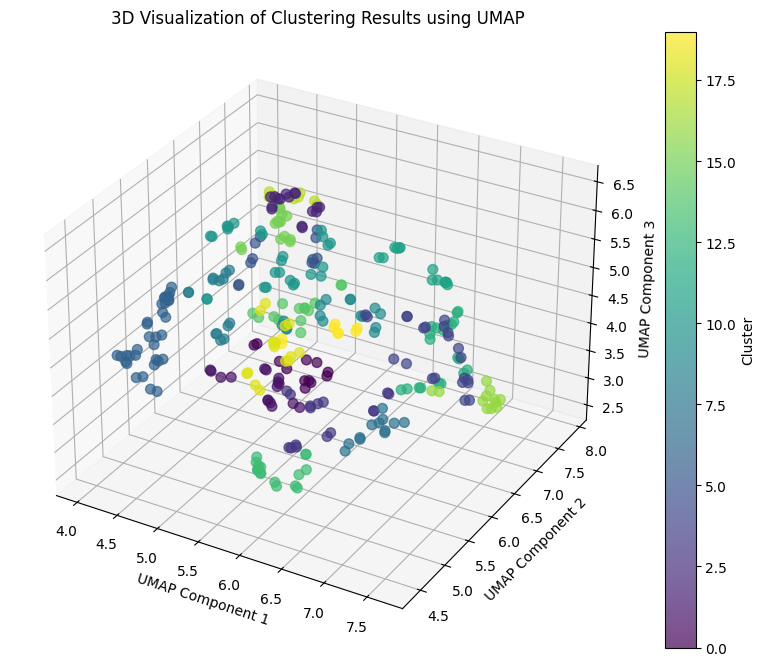

In [ ]:
# Assuming `flattened_matrices` contains the 1D vectors of upper triangles of the correlation matrices

# Step 1: Dimensionality reduction using UMAP to 3 dimensions
umap_reducer = umap.UMAP(
    n_components=3,
    n_neighbors=16,
    min_dist=0.01,
    random_state=42,
    spread=1,
    metric="correlation",
)
reduced_data = umap_reducer.fit_transform(flattened_matrices)

# Step 2: Perform K-Means clustering on the UMAP reduced data
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reduced_data)

# Step 3: Get the cluster labels for each scan
cluster_labels = kmeans.labels_

# Step 4: Plotting the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    reduced_data[:, 2],
    c=cluster_labels,
    cmap="viridis",
    s=50,
    alpha=0.7,
)

# Adding labels and title
ax.set_title("3D Visualization of Clustering Results using UMAP")
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
ax.set_zlabel("UMAP Component 3")

# Show color bar
plt.colorbar(scatter, label="Cluster")
plt.show()

In [ ]:
# Assume 'data' is your original data array
# cluster_labels is the prediction for the concatenated data

# Step 1: Initialize an array for the original shape of data with NaN
original_labels = np.full(data.shape[0], np.nan)

# Assuming data is 3D, adjust accordingly

# Step 2: Assign the cluster labels back
# For samples without NaNs
original_labels[~mask_nan] = cluster_labels[data_no_nans.shape[0] :]

# For samples with NaNs
original_labels[mask_nan] = cluster_labels[: data_with_nans.shape[0]]

submission_df = pd.DataFrame({"prediction": original_labels})
submission_df["prediction"] = submission_df["prediction"].astype(int)
# Save the submission to a CSV file
submission_df.to_csv("submissions/submission5.csv", index=False)

/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


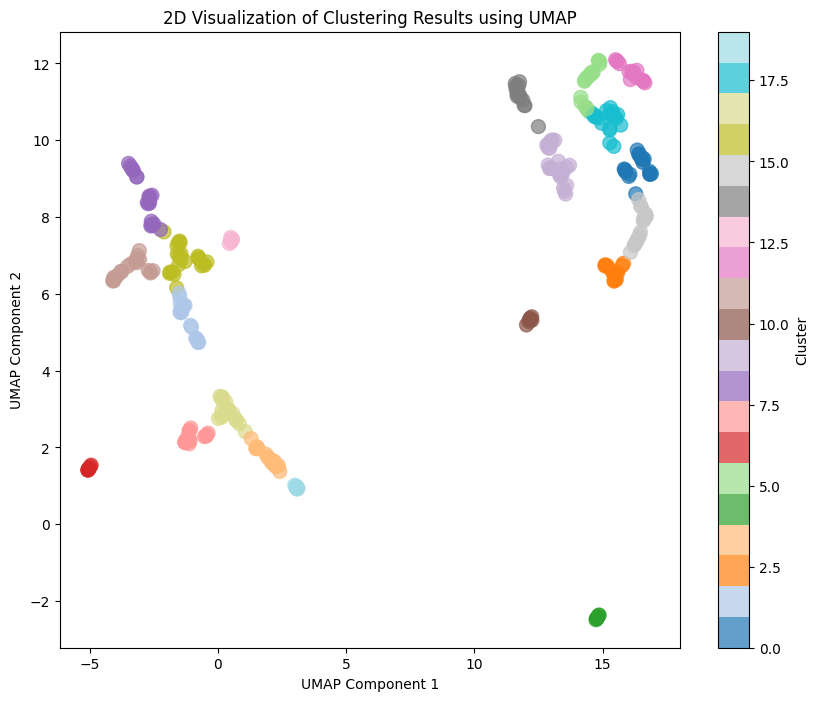

In [ ]:
# Assuming `flattened_matrices` contains the 1D vectors of upper triangles of the correlation matrices

# Step 1: Dimensionality reduction using UMAP to 2 dimensions
umap_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=16,
    min_dist=0.1,
    random_state=42,
    spread=1,  # metric="correlation"
)
reduced_data = umap_reducer.fit_transform(flattened_matrices)

# reduced_data = flattened_matrices

# Step 2: Perform K-Means clustering on the UMAP reduced data
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=1000)
kmeans.fit(reduced_data)

# Step 3: Get the cluster labels for each scan
cluster_labels = kmeans.labels_

# Step 4: Plotting the clusters in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=cluster_labels,
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

# Adding labels and title
plt.title("2D Visualization of Clustering Results using UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Show color bar
plt.colorbar(scatter, label="Cluster")
plt.show()

In [ ]:
# Assume 'data' is your original data array
# cluster_labels is the prediction for the concatenated data

# Step 1: Initialize an array for the original shape of data with NaN
original_labels = np.full(data.shape[0], np.nan)

# Assuming data is 3D, adjust accordingly

# Step 2: Assign the cluster labels back
# For samples without NaNs
original_labels[~mask_nan] = cluster_labels[data_no_nans.shape[0] :]

# For samples with NaNs
original_labels[mask_nan] = cluster_labels[: data_with_nans.shape[0]]

submission_df = pd.DataFrame({"prediction": original_labels})
submission_df["prediction"] = submission_df["prediction"].astype(int)
# Save the submission to a CSV file
submission_df.to_csv("bullshit.csv", index=False)